In [1]:
import cv2
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random

In [2]:
name_line = {}
line_root = ET.parse('/mnt/process/data_first/cervix_image_with_mask_and_bbox/data1_zaochan_line_annotations.xml').getroot()
for image in line_root.findall('image'):
     pic_name = image.attrib['name']
     name = pic_name.split('_')[0]
     for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            name_line[name] = arr

line_root = ET.parse('/mnt/process/data_first/cervix_image_with_mask_and_bbox/data1_healthy_line_annotations.xml').getroot()
for image in line_root.findall('image'):
    
     pic_name = image.attrib['name']
     name = pic_name.split('_')[0]
     for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            name_line[name] = arr

uuid_scale={}
scale_root = ET.parse('/mnt/process/data_first/cervix_image_with_mask_and_bbox/scale_annotations.xml').getroot()
for image in scale_root.findall('image'):
    uuid = image.attrib['name'][:-4]
    for anno in image:
        if anno.tag == 'polyline':
            arr = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            scale = arr[1][1]-arr[0][1]
            uuid_scale[uuid]=scale       


base_dir = '/mnt/process/data_first/cervix_image_with_mask_and_bbox/images'
root = ET.parse('/mnt/process/data_first/cervix_image_with_mask_and_bbox/annotations.xml').getroot()
name_df = pd.read_csv('/mnt/process/data_first/uuid_name.csv',index_col=0)
info_df = pd.read_csv('/mnt/process/data_first/yunzhou.csv',index_col=0)


cervixs=[]
labels=[]
names=[]
uuids=[]
polygons=[]
boxes=[]
img_paths=[]
scales=[]
masks = []
lines = []



for image in root.findall('image'):
    flag=True
    path = image.attrib['name']
    img_path = os.path.join(base_dir, path)   
    uuid = path.split('/')[-1][:-4]  
    for anno in image:
        if anno.tag == 'box':
            xtl = round(float(anno.attrib['xtl']))
            ytl = round(float(anno.attrib['ytl']))
            xbr = round(float(anno.attrib['xbr']))
            ybr = round(float(anno.attrib['ybr']))
            box=np.array([xtl,ytl,xbr,ybr])
           
        elif anno.tag == 'polygon':
            polygon = np.array(list(map(
                lambda x: np.array(x.strip().split(','), dtype=np.float32),
                anno.attrib['points'].split(';')
            )))
            mask =  np.around(polygon).astype(np.int32)
            
    
    try:
        name = name_df.loc[uuid]['Source'] 
        name = name.split('/')[-1].split('_')[0]
    except:
        # print('Person not found')
        flag=False

    try:
        label = info_df.loc[name]['自发性早产诊断']
        # print(label)
    except:
        # print('Label not found')
        flag=False

    try:
        cervix = info_df.loc[name]['孕中期宫颈长度']
        if np.isnan(cervix):
           flag = False
        #    print(name)
    except:
        # print('Cervix not found')
        flag=False
    

    if name in name_line:
        line = name_line[name]
    else:
        flag= False

    scale = uuid_scale[uuid]
    
    if flag:
        cervixs.append(cervix)
        labels.append(label)
        names.append(name)
        uuids.append(uuid)
        polygons.append(polygon)
        boxes.append(box)
        img_paths.append(img_path)
        scales.append(scale)
        masks.append(mask)
        lines.append(line)
        


    

print(len(labels))
print(len(cervixs))
print(len(scales))
print(len(lines))
    


钟敏
229
229
229
229


Train:
0.668649885583524


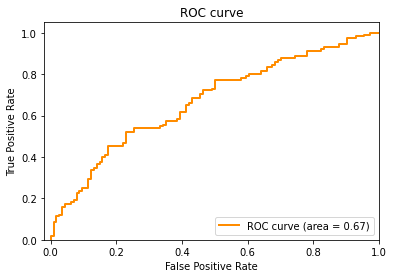

In [7]:

#回归
y = np.array(labels,dtype=np.float32)
x = []
for line,scale in zip(lines,scales):
    x0 = line[0][0]
    y0 = line[0][1]
    x1 = line[1][0]
    y1 = line[1][1]
    length =((x0-x1)**2 + (y0-y1)**2)**0.5
    length /= scale
    x.append([length])



def print_result(y_pred,y_test):
    fpr, tpr, _ = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
   
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc
    


def train_and_test(need_test):
    if need_test:
        seed = random.randint(0,1000000)
        test_size=0.2
      
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,random_state=seed,stratify=y)
    else:
        x_train,y_train = x,y


    model= LogisticRegression()
    model.fit(x_train,y_train)
    train_pred=model.predict_proba(x_train)[:,1]
    print("Train:")
    print_result(train_pred,y_train)
    if need_test:
        y_pred=model.predict_proba(x_test)[:,1]     
        print("Test:")
        print_result(y_pred,y_test)

train_and_test(False)